In [2]:
import numpy as np

import seaborn as sns
sns.set(style='whitegrid')

import pandas as pd
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import dask.dataframe as dd 

StatementMeta(Spark1, 104, 2, Finished, Available)

In [3]:
# The file is located in the Azure Data Lake Storage and needs to be converted from the PySpark Dataframe to Pandas Dataframe.

df = dd.read_csv('***/Lending_club_loan_data.csv', dtype={'desc': 'object', 'id':'object', 'sec_app_earliest_cr_line':'object'}, low_memory=False)
data = df.compute() 

# We'll make copy of the data, in case we need it in the future
data_copy = df.compute()

StatementMeta(Spark1, 104, 3, Finished, Available)

In [4]:
data.head()

StatementMeta(Spark1, 104, 4, Finished, Available)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300

In [5]:
data.shape

StatementMeta(Spark1, 104, 5, Finished, Available)

(2260701, 151)

In [6]:
# Let's check how many columns have more than 50% or more missing data

data.isnull().sum()

StatementMeta(Spark1, 104, 6, Finished, Available)

id                                                  0
member_id                                     2260701
loan_amnt                                          33
funded_amnt                                        33
funded_amnt_inv                                    33
term                                               33
int_rate                                           33
installment                                        33
grade                                              33
sub_grade                                          33
emp_title                                      167002
emp_length                                     146940
home_ownership                                     33
annual_inc                                         37
verification_status                                33
issue_d                                            33
loan_status                                        33
pymnt_plan                                         33
url                         

In [7]:
# We will drop those columns, since it can be very difficult to fill in values for so many missing rows
# Another thing is that there are 151 feature, and the goal is to reduce that number as much as possible
# We need to make sure that we don't write off valuable data

keep_columns = data.columns[((data.isnull().sum()/len(data))*100 < 50)].to_list()
data = data[keep_columns]

StatementMeta(Spark1, 104, 7, Finished, Available)

In [8]:
def frequency_histogram(plot_data, type):
    count_classes = data.value_counts(plot_data, sort = True).sort_index()
    count_classes.plot(kind = 'bar')
    plt.xlabel(type)
    plt.ylabel("Frequency")
    plt.show()

StatementMeta(Spark1, 104, 8, Finished, Available)

StatementMeta(Spark1, 104, 9, Finished, Available)

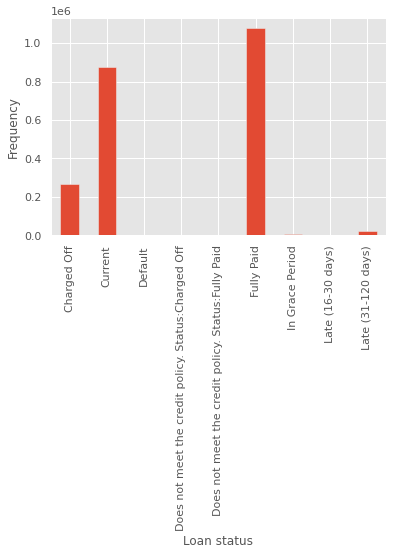

In [9]:
# The class lable in this case is loan_status

frequency_histogram(data['loan_status'], 'Loan status')

In [10]:
# For our further analysis, we will only keep the Fully Paid and Charged Off values and convert them into 0(Fully Paid) and 1(Charged Off)

data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
data.loan_status.replace(('Fully Paid', 'Charged Off'), (0, 1), inplace=True) 

StatementMeta(Spark1, 104, 10, Finished, Available)

StatementMeta(Spark1, 104, 11, Finished, Available)

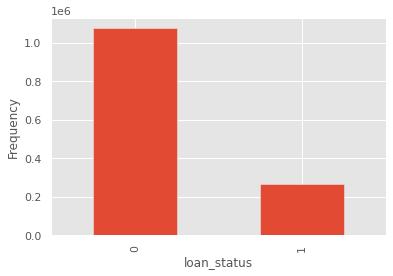

In [11]:
frequency_histogram(data['loan_status'], 'loan_status')

In [12]:
# Let's now check how imbalanced our dataset is 

loan_data = data['loan_status'].value_counts()
loan_data_norm = data['loan_status'].value_counts(normalize=True)

print('Positive class: {}({} %)'.format(loan_data[0], round(loan_data_norm[0], 4)*100.0))
print('Negative class: {}({} %)'.format(loan_data[1], round(loan_data_norm[1], 4)*100.0))
print('Proportion:', round(loan_data[0] / loan_data[1], 2), ': 1')

# Negative class occupies ~20% of all instances, so we have a moderate degree of imbalance.

StatementMeta(Spark1, 104, 12, Finished, Available)

Positive class: 1076751(80.04 %)
Negative class: 268559(19.96 %)
Proportion: 4.01 : 1


In [13]:
# Since we are dealing with imbalanced data, the correlation index might not be the best indicator on the feature dependency
# In case we would check this index, we would only keep the features that have coefficient >= +0.8 or <= -0.8
# What we can check is the values that have NaN coefficient value

correlation_matrix = data.corr()
correlation_matrix['loan_status'].sort_values(ascending=False)

StatementMeta(Spark1, 104, 13, Finished, Available)

loan_status                   1.000000
recoveries                    0.505415
collection_recovery_fee       0.480216
int_rate                      0.258792
total_rec_late_fee            0.141032
acc_open_past_24mths          0.099869
all_util                      0.089014
num_tl_op_past_12m            0.085623
dti                           0.084510
open_rv_24m                   0.081912
num_actv_rev_tl               0.070814
num_rev_tl_bal_gt_0           0.069425
percent_bc_gt_75              0.067379
bc_util                       0.066152
funded_amnt                   0.065658
loan_amnt                     0.065604
inq_last_6mths                0.065454
funded_amnt_inv               0.065445
open_rv_12m                   0.063358
revol_util                    0.060048
open_acc_6m                   0.059005
inq_last_12m                  0.058555
total_rec_int                 0.055718
installment                   0.051701
il_util                       0.045885
num_actv_bc_tl           

In [14]:
# What we can see is that following features have the same value throughout all rows
# We can remove those features, since they will not have an effect in the model training

print(data['out_prncp'].value_counts())
print(data['out_prncp_inv'].value_counts())
print(data['policy_code'].value_counts())

StatementMeta(Spark1, 104, 14, Finished, Available)

0.0    1345310
Name: out_prncp, dtype: int64
0.0    1345310
Name: out_prncp_inv, dtype: int64
1.0    1345310
Name: policy_code, dtype: int64


In [15]:
data.drop(['out_prncp', 'out_prncp_inv', 'policy_code'], axis=1, inplace=True)

StatementMeta(Spark1, 104, 15, Finished, Available)

In [16]:
data.shape

StatementMeta(Spark1, 104, 16, Finished, Available)

(1345310, 104)

In [17]:
# After checking the features and their description (found int the LCDataDictionary.csv file: https://github.com/dosei1/Lending-Club-Loan-Data/blob/master/LCDataDictionary.csv), 
# we were able to write off many features
# The ones that are left to be checked are the following:

final_columns = ['installment', 'addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'application_type',
                    'initial_list_status', 'int_rate', 'loan_amnt', 'num_actv_bc_tl', 'loan_status', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
                    'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status']
data = data[final_columns]

StatementMeta(Spark1, 104, 17, Finished, Available)

In [18]:
# These methods return information on the missing data

d_missing = ((data.isnull().sum()/len(data))*100)[((data.isnull().sum()/len(data))*100) > 0]

def missing_values(column):
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")
    else:
        return("No missing values")

def list_missing_data():
    for column in data.columns:
        if data[column].isna().sum() != 0:
            missing = data[column].isna().sum()
            portion = (missing / data.shape[0]) * 100
            print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")        

StatementMeta(Spark1, 104, 18, Finished, Available)

In [20]:
def plot_var(col_name, full_name, continuous):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,6))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(data.loc[data[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(data[col_name], order=sorted(data[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=data, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = data.groupby(col_name)['loan_status'].value_counts(normalize=True)[:, 1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(data, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(data[col_name].min(), data[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=data, order=sorted(data[col_name].unique()) )
    
    plt.show()


def plot_numerical(df,colname,name):    
    fig , (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.set_facecolor("lightgrey")

    sns.boxplot(y= colname,x='loan_status',data=df,ax=ax1)
    ax1.set_ylabel(name, fontsize=14,family = "Comic Sans MS")
    ax1.set_xlabel('Count', fontsize=14,family = "Comic Sans MS")
    ax1.set_title(name + ' by Loan Status', fontweight="bold",fontsize=15,family = "Comic Sans MS")

    sns.distplot(df[colname],color='y',ax=ax2,kde=True)
    
    mean = df[colname].mean()
    median = df[colname].median()
    mode = df[colname].mode()[0]
    
    label_mean= ("Mean :  {:.2f}".format(mean))
    label_median = ("Median :  {:.2f}".format(median))
    label_mode = ("Mode :  {:.2f}".format(mode))
    
    ax2.set_title("Distribution of " + name, fontweight="bold",fontsize=15,family = "Comic Sans MS")
    ax2.set_ylabel('Density', fontsize=12,family = "Comic Sans MS")
    ax2.set_xlabel(name, fontsize=12,family = "Comic Sans MS")
    ax2.axvline(mean,color="g",label=label_mean)
    ax2.axvline(median,color="b",label=label_median)
    ax2.axvline(mode,color="r",label=label_mode)
    ax2.legend()

    facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
    facet.map(sns.kdeplot, colname, shade=True)
    #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
    facet.add_legend()  

    plt.show()


def stack_bar_h(df,colname,name):
    cross_tab_pct = pd.crosstab(index=df[colname],
                            columns=df['loan_status'],normalize="index")
    cross_tab = pd.crosstab(index=df[colname],columns=df['loan_status'])
    
    cross_tab_pct.plot(kind='barh',stacked=True, colormap='summer', figsize=(10, 18))

    plt.legend(loc="lower right", ncol=2)
    plt.xlabel(name,fontsize=14,family = "Comic Sans MS")
    plt.ylabel("Loan Status",fontsize=14,family = "Comic Sans MS")
    plt.xticks(rotation=0)

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_pct.loc[x],cross_tab.loc[x],
                                            cross_tab_pct.loc[x].cumsum()):

            plt.text(x=(y_loc - proportion) + (proportion / 2),y=n - 0.11,
                    s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                    color="black", fontsize=10,)

    plt.show()


def stack_bar(df,colname,name):
    cross_tab_pct = pd.crosstab(index=df[colname],
                            columns=df['loan_status'],normalize="index")
    cross_tab = pd.crosstab(index=df[colname],columns=df['loan_status'])
    
    cross_tab_pct.plot(kind='bar', stacked=True, colormap='summer', figsize=(10, 6))

    plt.legend(loc="upper right", ncol=2)
    plt.xlabel(name,fontsize=14,family = "Comic Sans MS")
    plt.ylabel("Loan Status",fontsize=14,family = "Comic Sans MS")
    plt.xticks(rotation=0)

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_pct.loc[x],
                                              cross_tab.loc[x],
                                              cross_tab_pct.loc[x].cumsum()):

            plt.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2),
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                     color="black",fontsize=12,fontweight="bold")

    plt.show()

StatementMeta(Spark1, 104, 20, Finished, Available)

In [21]:
# addr_state - The state provided by the borrower in the loan application

# Values range from 13% in DC to 26% in MS, so we can keep this feature

data.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,1].sort_values()

StatementMeta(Spark1, 104, 21, Finished, Available)

addr_state
DC    0.132086
ME    0.138424
VT    0.139517
IA    0.142857
OR    0.143850
NH    0.145759
WV    0.155187
CO    0.155269
WA    0.157565
SC    0.162769
KS    0.167438
WY    0.167693
MT    0.168716
UT    0.170586
CT    0.173763
RI    0.178675
IL    0.180974
WI    0.183510
GA    0.183927
ID    0.188277
MA    0.190528
CA    0.196104
AZ    0.196299
AK    0.196552
MN    0.197430
DE    0.197462
TX    0.198223
VA    0.199422
HI    0.202013
MI    0.202957
ND    0.204744
OH    0.205283
NC    0.207839
PA    0.207921
KY    0.209829
NJ    0.211212
MO    0.212935
MD    0.213085
SD    0.213227
NM    0.213665
TN    0.214079
IN    0.214082
FL    0.214746
NV    0.219223
NY    0.220435
LA    0.231821
OK    0.234753
AL    0.236321
AR    0.240868
NE    0.251813
MS    0.260777
Name: loan_status, dtype: float64

In [22]:
data['addr_state'].describe()

StatementMeta(Spark1, 104, 22, Finished, Available)

count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

In [23]:
# earliest_cr_line - The month the borrower's earliest reported credit line was opened
# https://www.investopedia.com/terms/l/lineofcredit.asp

# This column represents a date, we can remove the month part

data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda s: int(s[-4:]))

StatementMeta(Spark1, 104, 23, Finished, Available)

StatementMeta(Spark1, 104, 24, Finished, Available)

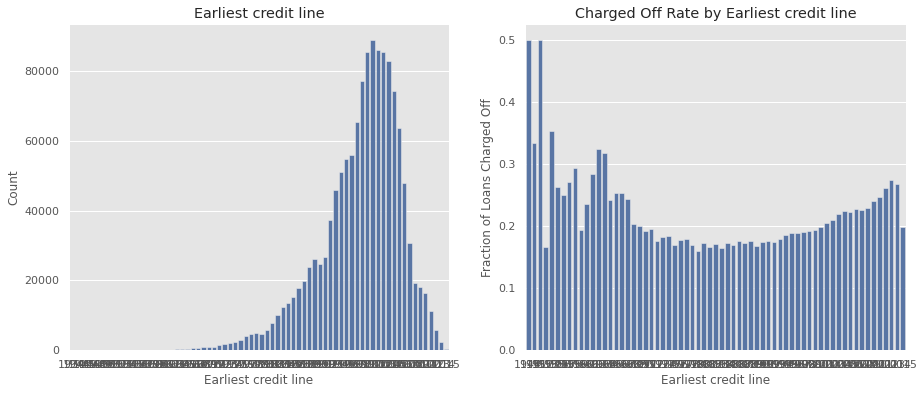

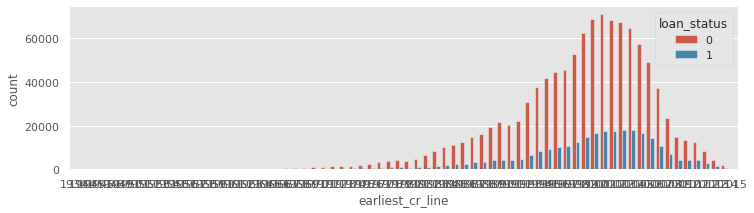

In [24]:
# This feature should be kept as well, charge-off rate varies from 16% - 50%

plot_var('earliest_cr_line', 'Earliest credit line', continuous=False)

In [25]:
# emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

# There are variations in the charge-off rate for the employment length, we wil keep this featre

data['emp_length'].value_counts()

StatementMeta(Spark1, 104, 25, Finished, Available)

10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64

StatementMeta(Spark1, 104, 26, Finished, Available)

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


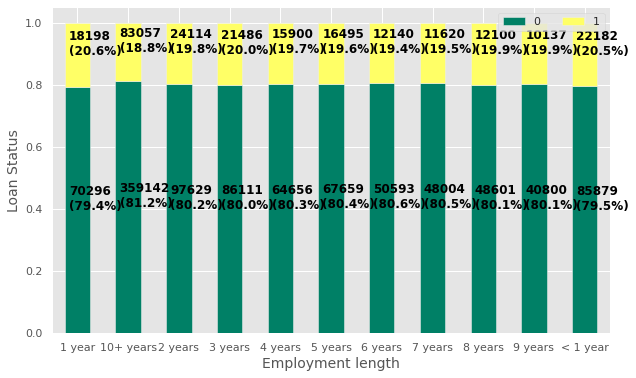

In [26]:
stack_bar(data,'emp_length', 'Employment length')

In [27]:
# emp_title - The job title supplied by the Borrower when applying for the loan

# There are too many unique titles for this feature to be useful, so we will drop it

data['emp_title'].describe()

StatementMeta(Spark1, 104, 27, Finished, Available)

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

In [28]:
data.drop('emp_title', axis=1, inplace=True)

StatementMeta(Spark1, 104, 28, Finished, Available)

In [29]:
# grade - LC assigned loan grade
# subgrade - LC assigned loan subgrade

print(sorted(data['grade'].unique()))
print()
print(sorted(data['sub_grade'].unique()))

StatementMeta(Spark1, 104, 29, Finished, Available)

['A', 'B', 'C', 'D', 'E', 'F', 'G']

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [30]:
# Let's drp grade column since it has fewer values than sybgrade (also subgrase is a part of grade)

data.drop('grade', axis=1, inplace=True)

StatementMeta(Spark1, 104, 30, Finished, Available)

StatementMeta(Spark1, 104, 31, Finished, Available)

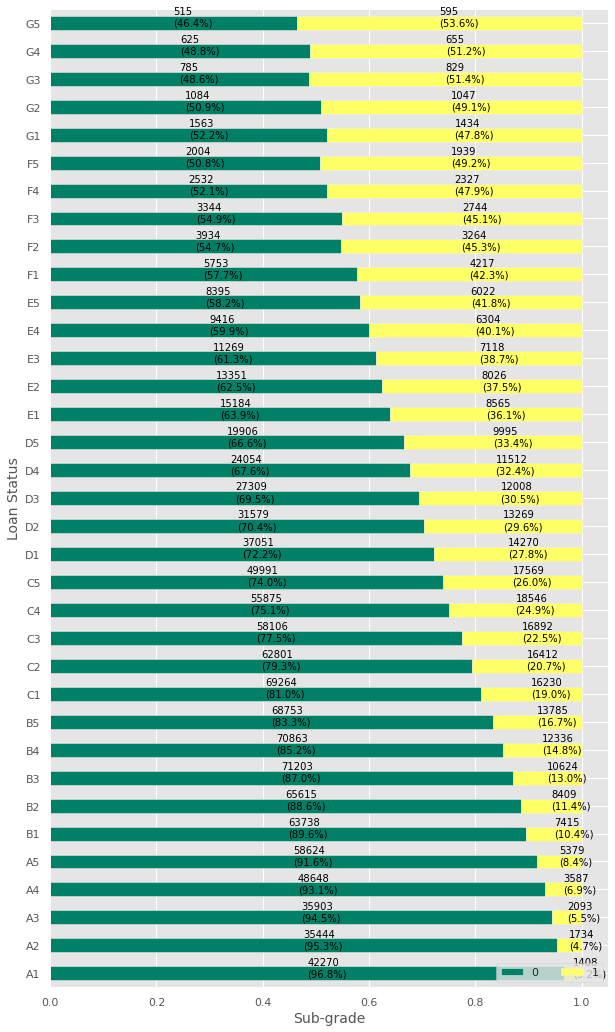

In [31]:
# Looking at the graphs, we can see that there is a strong connection between sub_grades and charging off
# There is also a connection between grade and a charge-off rate, 

stack_bar_h(data,'sub_grade', 'Sub-grade')

In [32]:
# home_ownership - The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

data['home_ownership'].value_counts()

StatementMeta(Spark1, 104, 32, Finished, Available)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [33]:
# ANY and NONE values can be moved to the OTHER categpry

data['home_ownership'] = data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
data['home_ownership'].value_counts()

StatementMeta(Spark1, 104, 33, Finished, Available)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

StatementMeta(Spark1, 104, 34, Finished, Available)

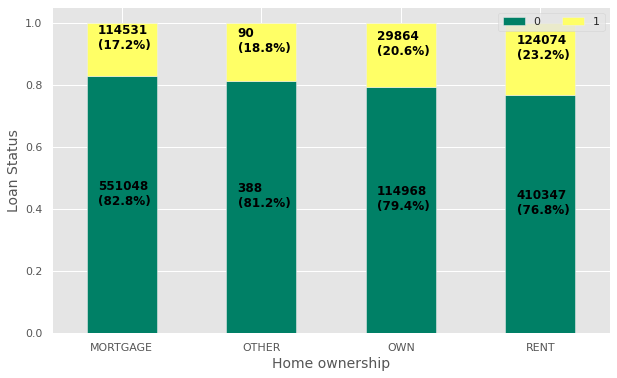

In [34]:
# Looking at the graph, we can keep this feature since there is a difference in charge-off rate and it varies from 17.2% to 23.2%

stack_bar(data,'home_ownership', 'Home ownership')

In [35]:
# application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers

data['application_type'].value_counts()

StatementMeta(Spark1, 104, 35, Finished, Available)

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

StatementMeta(Spark1, 104, 36, Finished, Available)

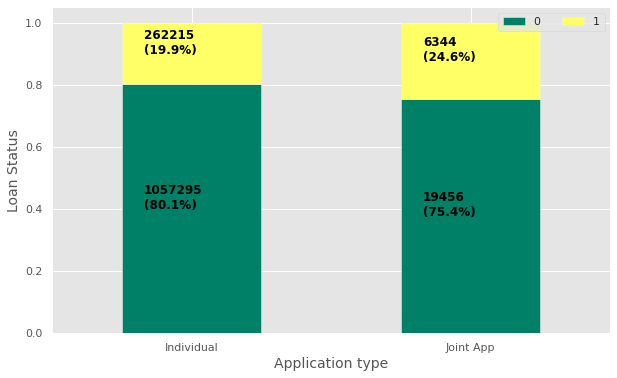

In [36]:
# We can keep this feature as well, because the charge-off rate varies from 19.9% - 24.6%
# The majority of the loans are individual applications and they are more possible to be charged off than joint app.

stack_bar(data,'application_type', 'Application type')

In [37]:
# initial_list_status - The initial listing status of the loan. Possible values are – W, F

data['initial_list_status'].value_counts()

StatementMeta(Spark1, 104, 37, Finished, Available)

w    784010
f    561300
Name: initial_list_status, dtype: int64

StatementMeta(Spark1, 104, 38, Finished, Available)

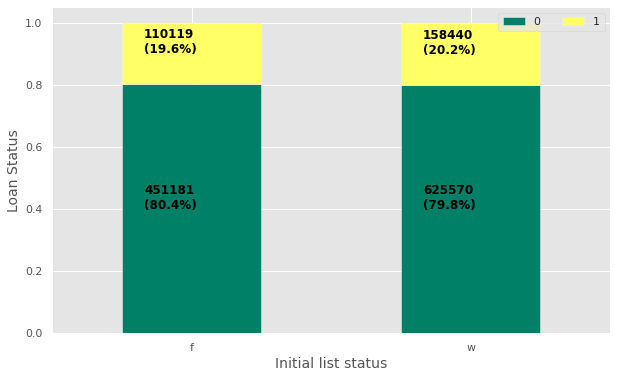

In [38]:
# There is a slight difference in the charge-off rate
# More info on the feature: "The variable initial_list_status is available in the public data and identifies whether a loan 
# was initially listed in the whole (W) or fractional (F) market."
# It doesn't seem important for our further analysis, so we can drop it

stack_bar(data,'initial_list_status', 'Initial list status')

In [39]:
data.drop('initial_list_status', axis=1, inplace=True)

StatementMeta(Spark1, 104, 39, Finished, Available)

In [40]:
# purpose - A category provided by the borrower for the loan request. 
# title - The loan title provided by the borrower

data[['purpose', 'title']].head()

StatementMeta(Spark1, 104, 40, Finished, Available)

,purpose,title
0,debt_consolidation,Debt consolidation
1,small_business,Business
2,home_improvement,NaN
4,major_purchase,Major purchase
5,debt_consolidation,Debt consolidation


In [41]:
data['purpose'].describe()

StatementMeta(Spark1, 104, 41, Finished, Available)

count                1345310
unique                    14
top       debt_consolidation
freq                  780321
Name: purpose, dtype: object

In [42]:
data['title'].describe()

StatementMeta(Spark1, 104, 42, Finished, Available)

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

In [43]:
# These two features contain similar data, except that the title contains much more information
# In this case, our model would benefit more from the feature with less values
# so we will drop the title column 

data.drop('title',axis=1,inplace=True)

StatementMeta(Spark1, 104, 43, Finished, Available)

StatementMeta(Spark1, 104, 44, Finished, Available)

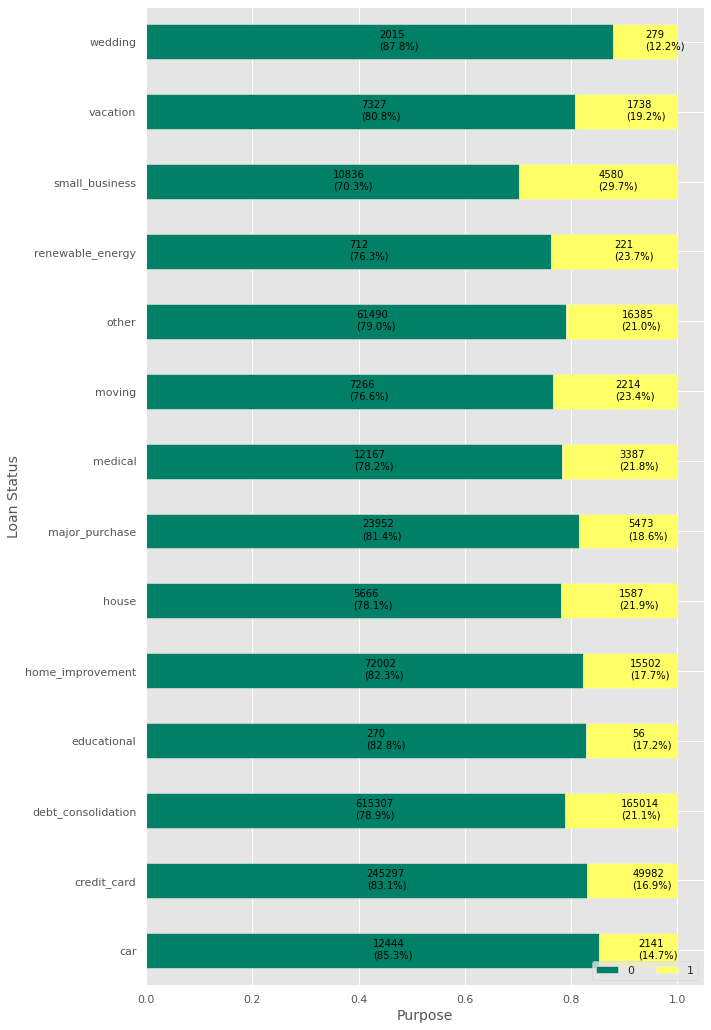

In [44]:
# From the graph, we see that there is a change in the charge-off rate compared to the purpose category,
# so we will keep the purpose feature

stack_bar_h(data,'purpose', 'Purpose')

In [45]:
# term - The number of payments on the loan. Values are in months and can be either 36 or 60.

data['term'].value_counts()

StatementMeta(Spark1, 104, 45, Finished, Available)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [47]:
# Let's leave only the 36/60 part -> (int)

data['term'] = data['term'].apply(lambda x: int(x[0:3]))

StatementMeta(Spark1, 104, 47, Finished, Available)

TypeError: 'int' object is not subscriptable

StatementMeta(Spark1, 104, 48, Finished, Available)

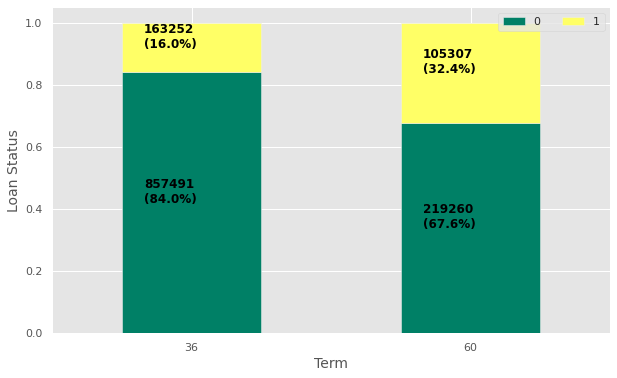

In [48]:
# In comparison to 36-month loans, 60-month loans have a ~ 2x higher rate of charge-offs
# We should keep this feature

stack_bar(data,'term', 'Term')

In [49]:
# verification_status - Indicates if income was verified by LC, not verified, or if the income source was verified

data['verification_status'].value_counts()

StatementMeta(Spark1, 104, 49, Finished, Available)

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

StatementMeta(Spark1, 104, 50, Finished, Available)

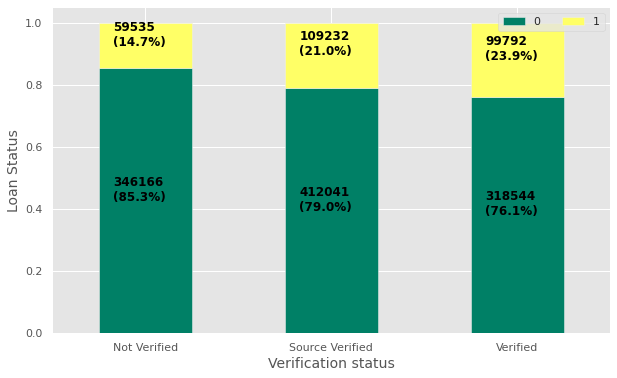

In [50]:
# We should deffinately keep this feature, since there is a difference in the charge-off rate (14% - 23%)

stack_bar(data,'verification_status','Verification status')

StatementMeta(Spark1, 104, 51, Finished, Available)

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


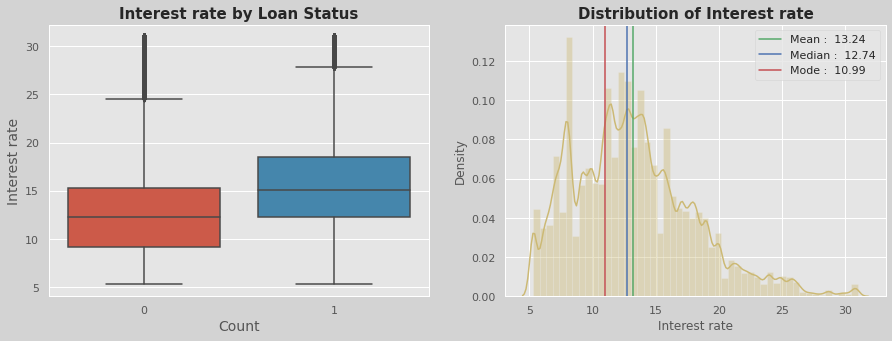

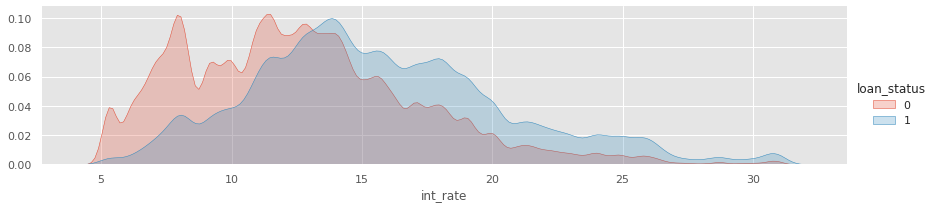

In [51]:
# int_rate - Interest Rate on the loan 

plot_numerical(data, 'int_rate', 'Interest rate')

In [52]:
# Charged-off loans tend to have higher median interest rates than the fully paid ones
# We will keep this feature

data.groupby(['loan_status'])['int_rate'].describe()

StatementMeta(Spark1, 104, 52, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99
1,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99


StatementMeta(Spark1, 104, 53, Finished, Available)

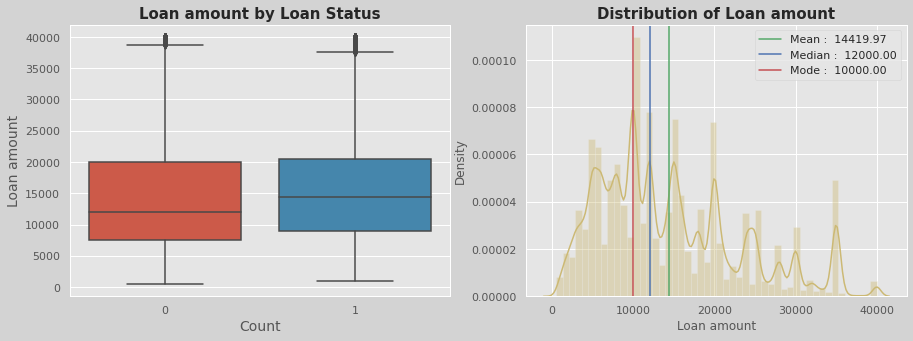

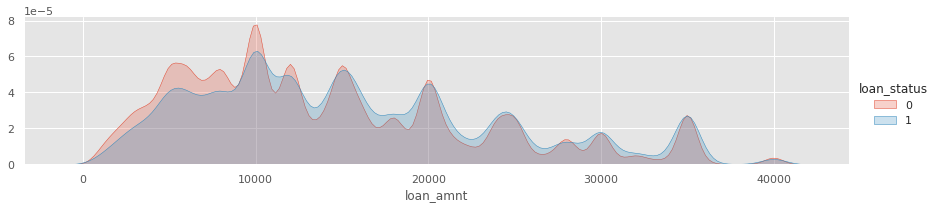

In [53]:
# loan_amnt - The listed amount of the loan applied for by the borrower. 
# If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

plot_numerical(data, 'loan_amnt', 'Loan amount')

In [54]:
missing_values('loan_amnt')

StatementMeta(Spark1, 104, 54, Finished, Available)

'No missing values'

In [55]:
# Charged-off loans tend to have higher median loan amounts than the fully paid ones
# We will keep this feature

data.groupby(['loan_status'])['loan_amnt'].describe()

StatementMeta(Spark1, 104, 55, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0
1,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0


StatementMeta(Spark1, 104, 56, Finished, Available)

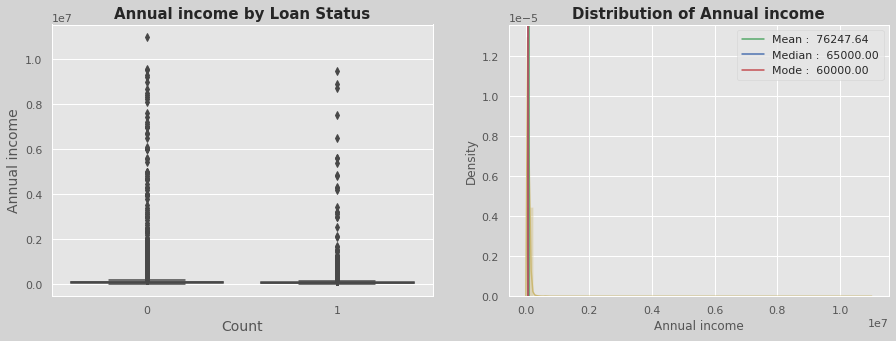

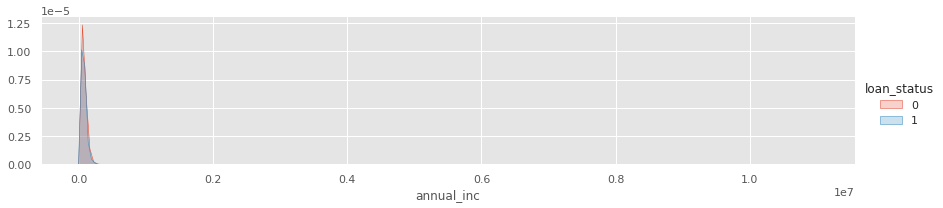

In [56]:
# annual_inc - The self-reported annual income provided by the borrower during registration.

plot_numerical(data, 'annual_inc', 'Annual income')

In [57]:
# Not much can be concluded from the graph above, since the values range from $0 to $10999200
# We will scale this range

data['annual_inc_lg'] = data['annual_inc'].apply(lambda x: np.log10(x+1))
data['annual_inc_lg'].describe()

StatementMeta(Spark1, 104, 57, Finished, Available)

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc_lg, dtype: float64

StatementMeta(Spark1, 104, 58, Finished, Available)

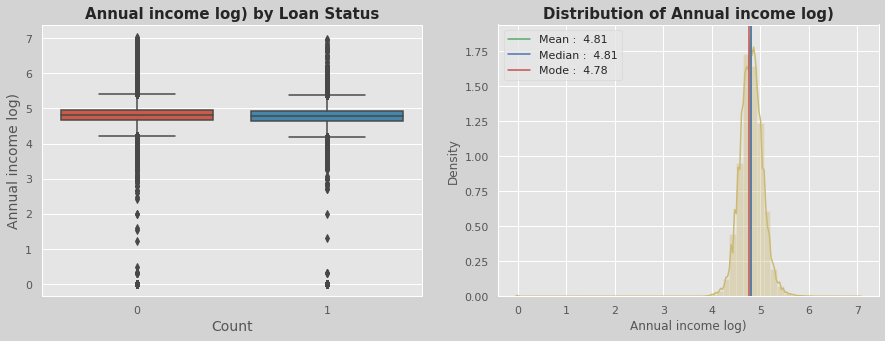

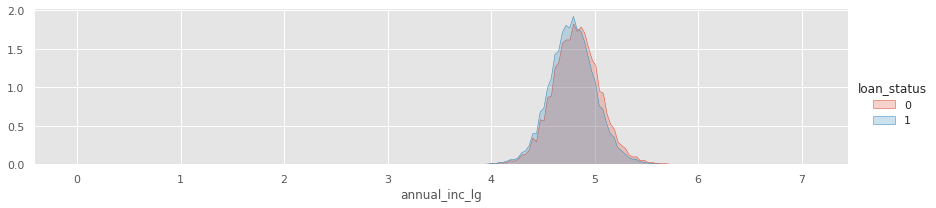

In [58]:
plot_numerical(data, 'annual_inc_lg', 'Annual income log)')

In [59]:
# There is a difference in the charge-off rate between people with higher income - people with higher annual income tend to pay off the loan

data.groupby(['loan_status'])['annual_inc_lg'].describe()

StatementMeta(Spark1, 104, 59, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1076751.0,4.820560,0.248526,0.0,4.672107,4.812920,4.968488,7.041361
1,268559.0,4.781756,0.241984,0.0,4.633479,4.778158,4.929424,6.977724


StatementMeta(Spark1, 104, 60, Finished, Available)

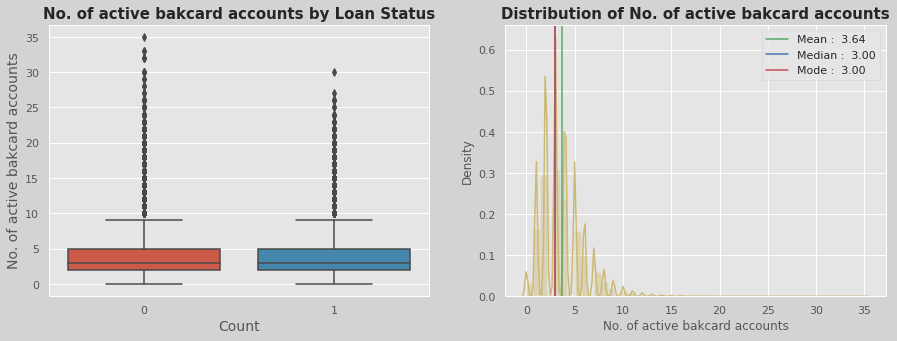

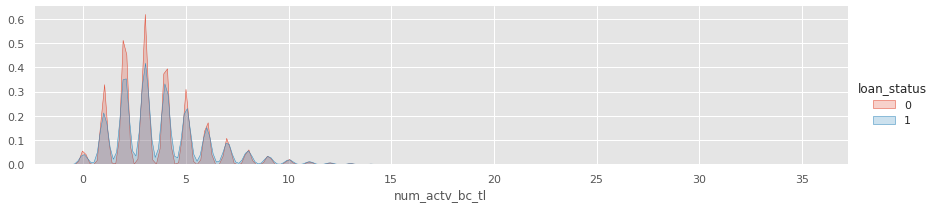

In [60]:
# num_actv_bc_tl - Number of currently active bankcard accounts

plot_numerical(data, 'num_actv_bc_tl', 'No. of active bakcard accounts')

In [62]:
# Some people have more than 10 accounts, which is not that ususal

data['num_actv_bc_tl'].value_counts().sort_index()

StatementMeta(Spark1, 104, 62, Finished, Available)

0.0      27343
1.0     146415
2.0     260750
3.0     273898
4.0     212435
5.0     141796
6.0      88124
7.0      51872
8.0      30482
9.0      18023
10.0     10636
11.0      6347
12.0      3778
13.0      2271
14.0      1276
15.0       850
16.0       489
17.0       367
18.0       219
19.0       149
20.0        75
21.0        52
22.0        43
23.0        26
24.0        22
25.0        13
26.0        14
27.0         3
28.0         2
29.0         2
30.0         5
32.0         3
33.0         2
35.0         1
Name: num_actv_bc_tl, dtype: int64

In [63]:
# Let's rop the rows having >= than 13 accounts and keep this feature

data = data[data['num_actv_bc_tl'] < 13]

StatementMeta(Spark1, 104, 63, Finished, Available)

In [64]:
data.groupby(['loan_status'])['num_actv_bc_tl'].describe()

StatementMeta(Spark1, 104, 64, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1015224.0,3.548118,2.089816,0.0,2.0,3.0,5.0,12.0
1,256675.0,3.762026,2.208203,0.0,2.0,3.0,5.0,12.0


StatementMeta(Spark1, 104, 65, Finished, Available)

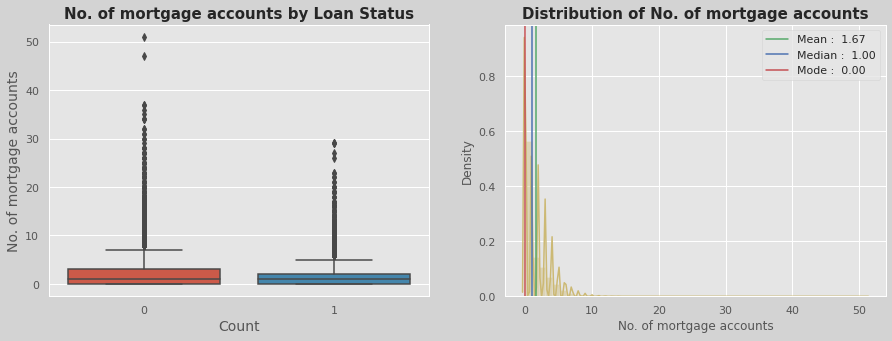

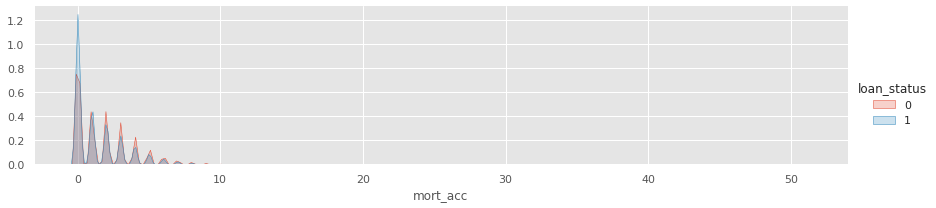

In [65]:
# mort_acc - Number of mortgage accounts.

plot_numerical(data, 'mort_acc', 'No. of mortgage accounts')

In [66]:
data['mort_acc'].value_counts().sort_index()

StatementMeta(Spark1, 104, 66, Finished, Available)

0.0     511633
1.0     221964
2.0     185980
3.0     137121
4.0      93251
5.0      56426
6.0      31822
7.0      16418
8.0       8149
9.0       4151
10.0      2124
11.0      1178
12.0       625
13.0       340
14.0       240
15.0       129
16.0        91
17.0        61
18.0        45
19.0        28
20.0        25
21.0        14
22.0        13
23.0        10
24.0        15
25.0         9
26.0         6
27.0         8
28.0         4
29.0         4
30.0         2
31.0         2
32.0         2
34.0         3
35.0         1
36.0         1
37.0         2
47.0         1
51.0         1
Name: mort_acc, dtype: int64

In [67]:
# Drop the rows having >- 12 accounts and keep this feature

data = data[data['mort_acc'] < 12]

StatementMeta(Spark1, 104, 67, Finished, Available)

In [68]:
data.groupby(['loan_status'])['mort_acc'].describe()

StatementMeta(Spark1, 104, 68, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,1.730519,1.971641,0.0,0.0,1.0,3.0,11.0
1,256465.0,1.359683,1.782189,0.0,0.0,1.0,2.0,11.0


StatementMeta(Spark1, 104, 69, Finished, Available)

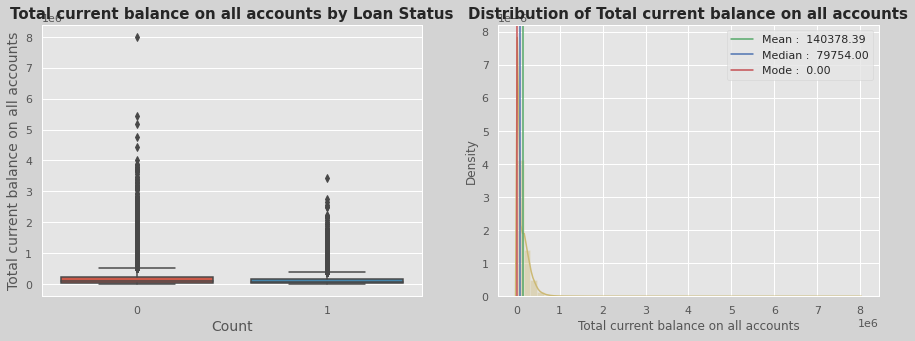

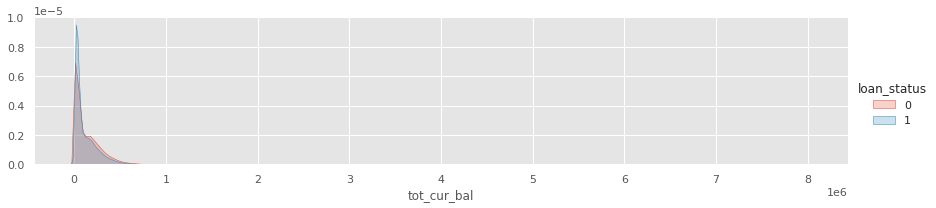

In [69]:
# tot_cur_bal - Total current balance of all accounts

plot_numerical(data, 'tot_cur_bal', 'Total current balance on all accounts')

In [70]:
data['tot_cur_bal'].describe()

StatementMeta(Spark1, 104, 70, Finished, Available)

count    1.270217e+06
mean     1.403784e+05
std      1.561492e+05
min      0.000000e+00
25%      2.932100e+04
50%      7.975400e+04
75%      2.098950e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [71]:
#  We need to get a better representation of our data, and for that we will scale value range using log function

data['tot_cur_bal_lg'] = data['tot_cur_bal'].apply(lambda x: np.log10(x+1))
data.groupby(['loan_status'])['tot_cur_bal_lg'].describe()

StatementMeta(Spark1, 104, 71, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,4.880597,0.564030,0.0,4.476350,4.939295,5.339193,6.903094
1,256465.0,4.798954,0.539522,0.0,4.436656,4.784731,5.241392,6.536215


StatementMeta(Spark1, 104, 72, Finished, Available)

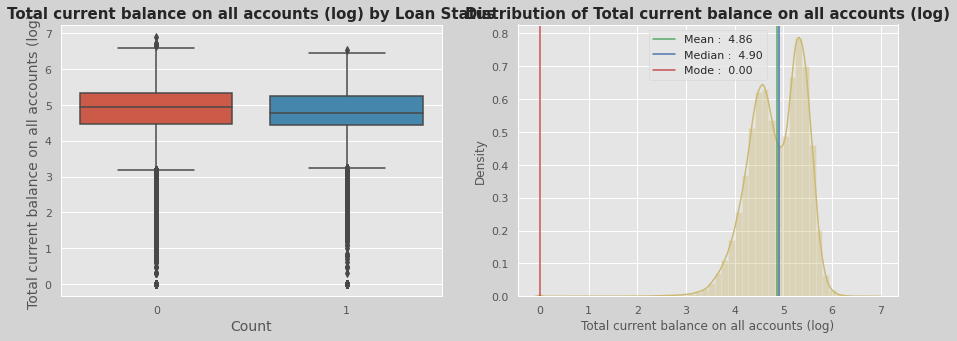

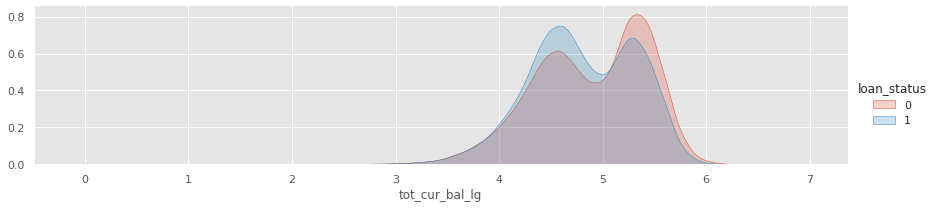

In [72]:
# We should keep this feature - we can see that this feature is more present in the case of the customers who fully paid the loan

plot_numerical(data, 'tot_cur_bal_lg', 'Total current balance on all accounts (log)')

StatementMeta(Spark1, 104, 73, Finished, Available)

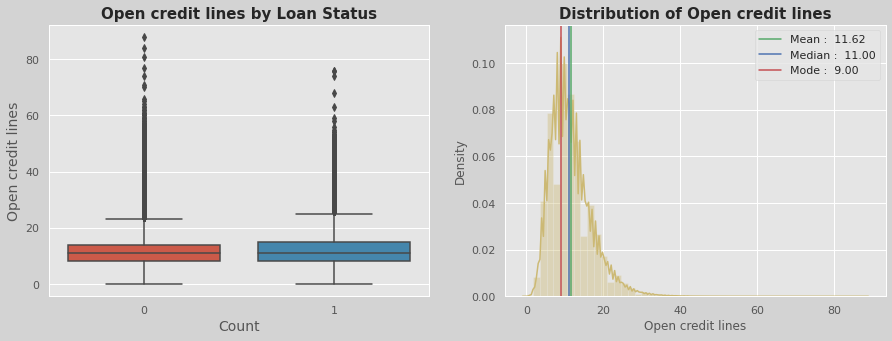

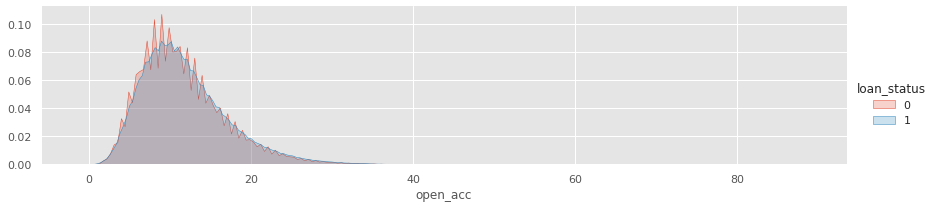

In [73]:
# open_acc - The number of open credit lines in the borrower's credit file.

# Let's keep this feature, there is a slight difference in the charge-off rate 

plot_numerical(data, 'open_acc', 'Open credit lines')

In [74]:
data.groupby(['loan_status'])['open_acc'].describe()

StatementMeta(Spark1, 104, 74, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,11.545775,5.348509,0.0,8.0,11.0,14.0,88.0
1,256465.0,11.889946,5.512869,0.0,8.0,11.0,15.0,76.0


StatementMeta(Spark1, 104, 75, Finished, Available)

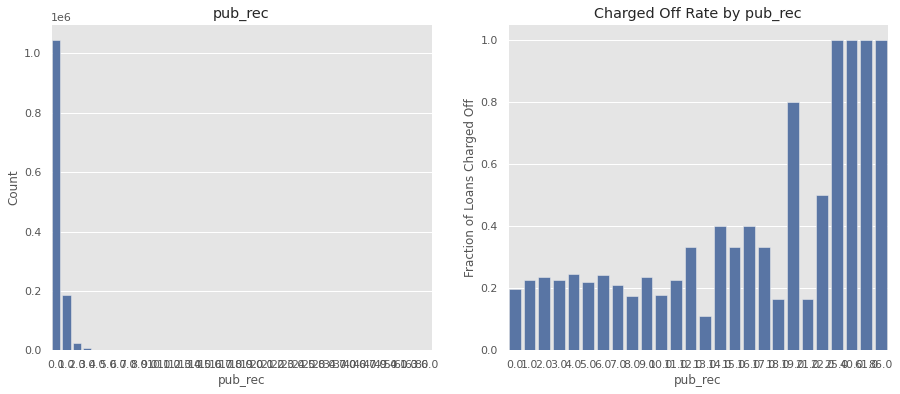

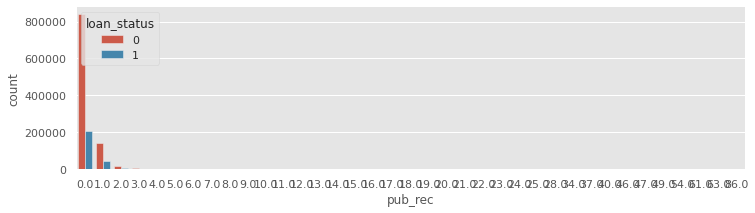

In [75]:
# pub_rec - Applicant’s number of derogatory public records

plot_var('pub_rec', 'pub_rec', continuous=False)

In [76]:
data['pub_rec'].value_counts()

StatementMeta(Spark1, 104, 76, Finished, Available)

0.0     1046182
1.0      187223
2.0       24241
3.0        7352
4.0        2607
5.0        1260
6.0         630
7.0         281
8.0         159
9.0          80
10.0         56
11.0         40
12.0         27
13.0         18
15.0          9
18.0          6
21.0          6
14.0          5
16.0          5
19.0          5
17.0          3
28.0          3
20.0          3
22.0          2
24.0          2
34.0          1
46.0          1
47.0          1
61.0          1
40.0          1
54.0          1
86.0          1
63.0          1
23.0          1
49.0          1
25.0          1
37.0          1
Name: pub_rec, dtype: int64

In [77]:
data.groupby(['loan_status'])['pub_rec'].describe()

StatementMeta(Spark1, 104, 77, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,0.216967,0.598146,0.0,0.0,0.0,0.0,63.0
1,256465.0,0.254620,0.667357,0.0,0.0,0.0,0.0,86.0


In [78]:
# pub_rec > 11 rows have significant number of charged-off loans, and also it has low counts 

data.pub_rec = data.pub_rec.map(lambda x: 3 if x >2.0 else x)

StatementMeta(Spark1, 104, 78, Finished, Available)

StatementMeta(Spark1, 104, 79, Finished, Available)

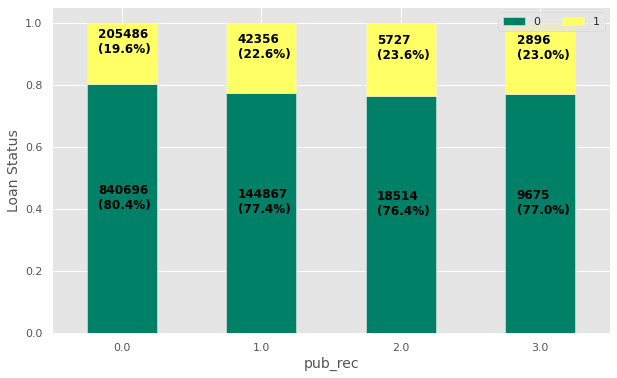

In [79]:
stack_bar(data, 'pub_rec', 'pub_rec')

In [80]:
# Means differ by a bit, let's keep this feature

data.groupby(['loan_status'])['pub_rec'].describe()

StatementMeta(Spark1, 104, 80, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,0.208059,0.508487,0.0,0.0,0.0,0.0,3.0
1,256465.0,0.243690,0.544720,0.0,0.0,0.0,0.0,3.0


In [81]:
# pub_rec_bankruptcies - Number of public record bankruptcies

# these two features are correlated, so we can keep only one of them

data[['pub_rec','pub_rec_bankruptcies']].corr()

StatementMeta(Spark1, 104, 81, Finished, Available)

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.733536
pub_rec_bankruptcies,0.733536,1.000000


StatementMeta(Spark1, 104, 82, Finished, Available)

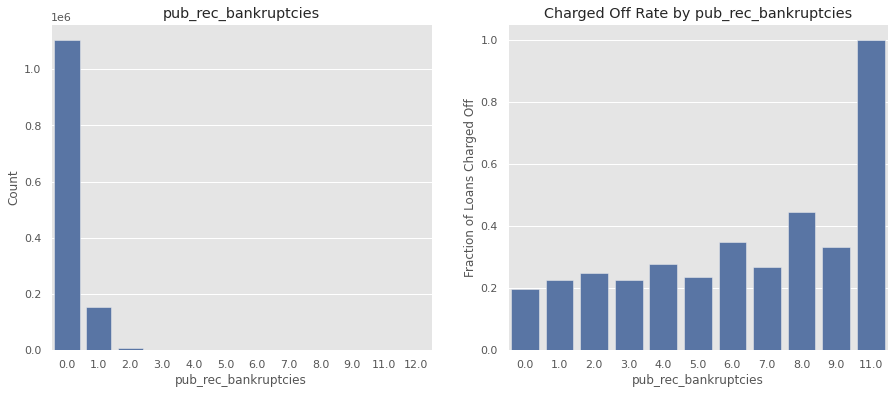

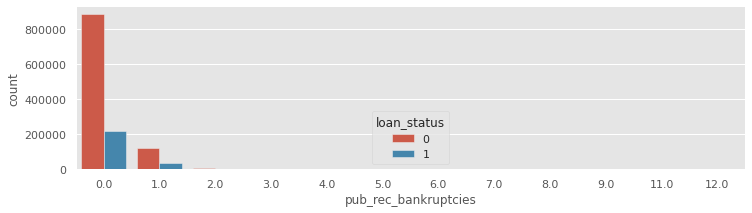

In [82]:
plot_var('pub_rec_bankruptcies', 'pub_rec_bankruptcies', continuous=False)

In [83]:
# Let's drop pub_rec_bankruptcies

data.drop('pub_rec_bankruptcies', axis=1, inplace=True)

StatementMeta(Spark1, 104, 83, Finished, Available)

StatementMeta(Spark1, 104, 84, Finished, Available)

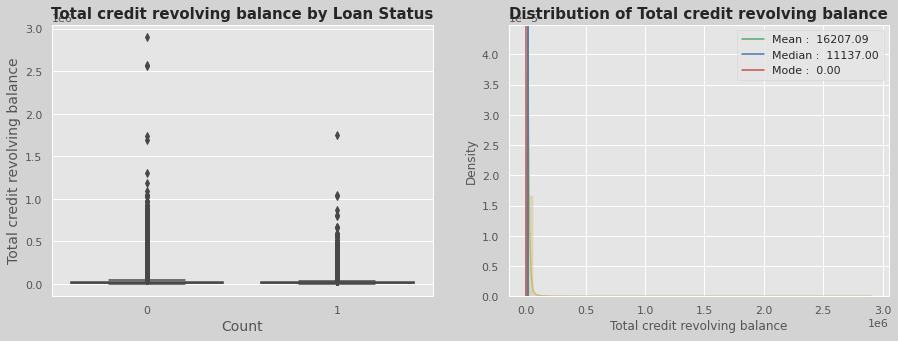

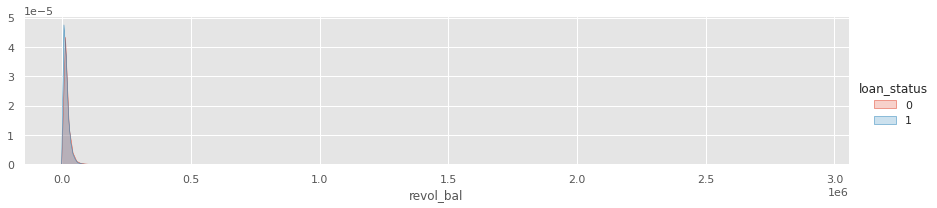

In [84]:
# revol_bal - Total credit revolving balance

plot_numerical(data, 'revol_bal', 'Total credit revolving balance')

In [85]:
data.groupby(['loan_status'])['revol_bal'].describe()

data['revol_bal_lg'] = data['revol_bal'].apply(lambda x:np.log10(x+1))

StatementMeta(Spark1, 104, 85, Finished, Available)

StatementMeta(Spark1, 104, 86, Finished, Available)

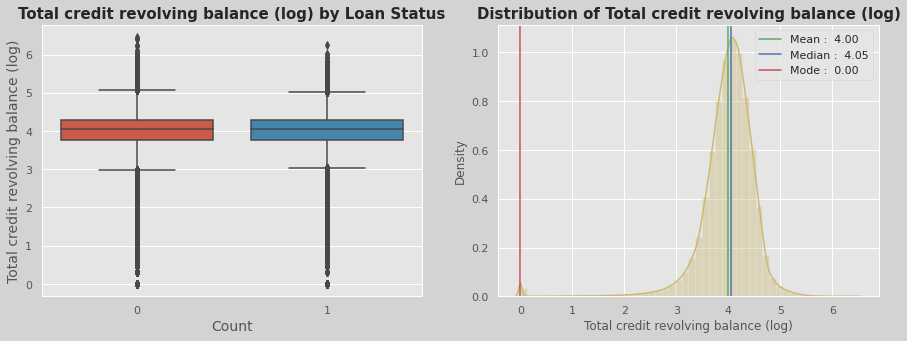

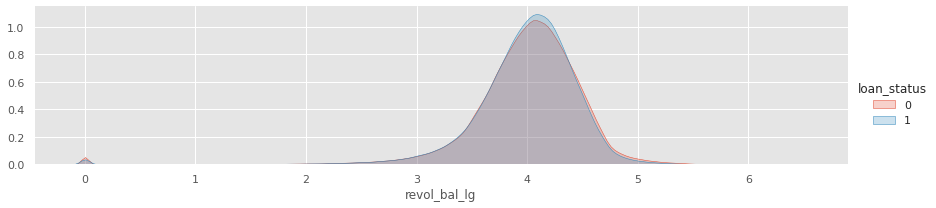

In [86]:
plot_numerical(data, 'revol_bal_lg', 'Total credit revolving balance (log)')

In [87]:
# There isn't big difference in the means, so we can drop this feature

data.groupby(['loan_status'])['revol_bal_lg'].describe()

data.drop(['revol_bal', 'revol_bal_lg'], axis=1, inplace=True)

StatementMeta(Spark1, 104, 87, Finished, Available)

StatementMeta(Spark1, 104, 88, Finished, Available)

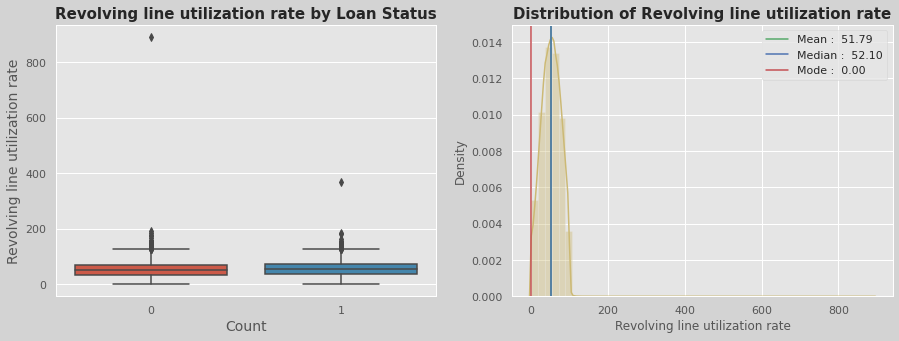

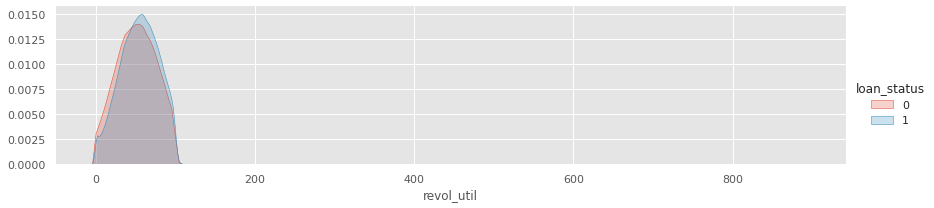

In [88]:
# revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

plot_numerical(data, 'revol_util', 'Revolving line utilization rate')

In [89]:
# We can keep this feature since there is a difference in the mean values for the charged-off and fully paid loans

data.groupby(['loan_status'])['revol_util'].describe()

StatementMeta(Spark1, 104, 89, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013131.0,51.081282,24.470949,0.0,32.6,51.2,69.9,892.3
1,256310.0,54.614073,23.763097,0.0,37.3,55.3,72.8,366.6


In [90]:
# total_acc - The total number of credit lines currently in the borrower's credit file

data['total_acc'].head()

StatementMeta(Spark1, 104, 90, Finished, Available)

0    13.0
1    38.0
2    18.0
4    35.0
5     6.0
Name: total_acc, dtype: float64

StatementMeta(Spark1, 104, 91, Finished, Available)

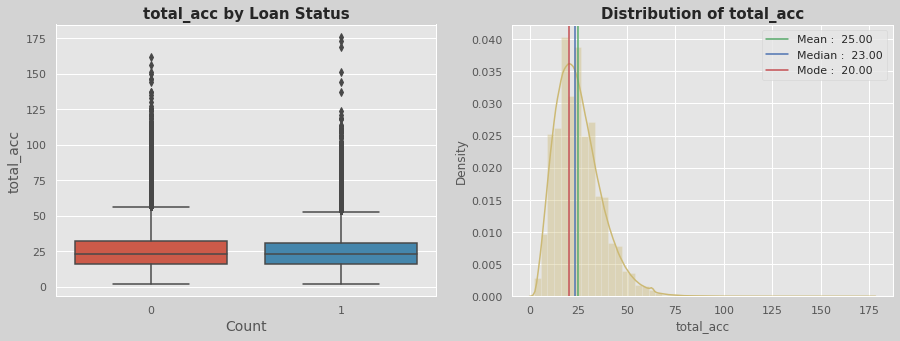

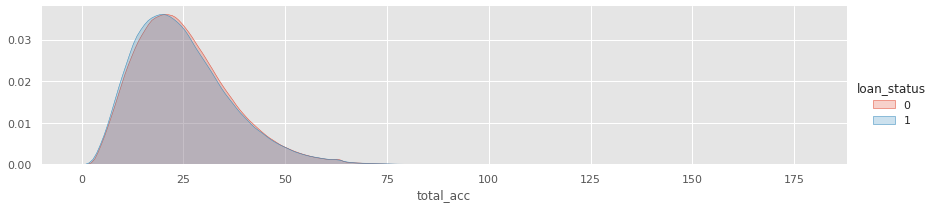

In [91]:
plot_numerical(data, 'total_acc', 'total_acc')

In [92]:
# There is a small difference in the means, so we can keep this feature

data.groupby(['loan_status'])['total_acc'].describe()

StatementMeta(Spark1, 104, 92, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,25.079026,11.889012,2.0,16.0,23.0,32.0,162.0
1,256465.0,24.689014,12.028972,2.0,16.0,23.0,31.0,176.0


In [93]:
# FICO scores: are a credit score: a number used by banks and credit cards to represent how credit-worthy a person is. 
# While there are a few types of credit scores used in the United States, the FICO score is the best known and most widely used.
# When a borrower applies for a loan, LendingClub gets the borrower’s credit score from FICO — 
# they are given a lower and upper limit of the range that the borrowers score belongs to, and they store those values as fico_range_low, fico_range_high. 
# After that, any updates to the borrowers score are recorded as last_fico_range_low, and last_fico_range_high.
# https://en.wikipedia.org/wiki/Credit_score_in_the_United_States#FICO_score

StatementMeta(Spark1, 104, 93, Finished, Available)

In [94]:
# fico_range_low - The lower boundary range the borrower’s FICO at loan origination belongs to.
# fico_range_high - The upper boundary range the borrower’s last FICO pulled belongs to.

# These two features are correlated, so we can keep only one of them

data[['fico_range_low','fico_range_high']].corr()

StatementMeta(Spark1, 104, 94, Finished, Available)

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [95]:
data.groupby(['loan_status'])['fico_range_low'].describe()

StatementMeta(Spark1, 104, 95, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,697.449943,32.490039,660.0,670.0,690.0,715.0,845.0
1,256465.0,687.390872,25.652224,660.0,670.0,680.0,700.0,845.0


In [96]:
data.groupby(['loan_status'])['fico_range_high'].describe()

StatementMeta(Spark1, 104, 96, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,701.450110,32.490798,664.0,674.0,694.0,719.0,850.0
1,256465.0,691.390927,25.652561,664.0,674.0,684.0,704.0,850.0


StatementMeta(Spark1, 104, 97, Finished, Available)

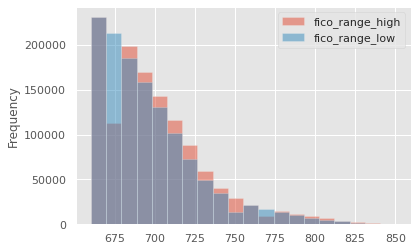

In [97]:
fico_columns = ['fico_range_high','fico_range_low']
data[fico_columns].plot.hist(alpha=0.5,bins=20)
plt.show()

In [98]:
# Both fico_range_high and fico_range_low have similar mean and standard deviation, so, we will use mean of both scores

data['fico'] = (data['fico_range_high'] + data['fico_range_low']) / 2
data = data.drop(['fico_range_high', 'fico_range_low'], axis=1)

StatementMeta(Spark1, 104, 98, Finished, Available)

StatementMeta(Spark1, 104, 99, Finished, Available)

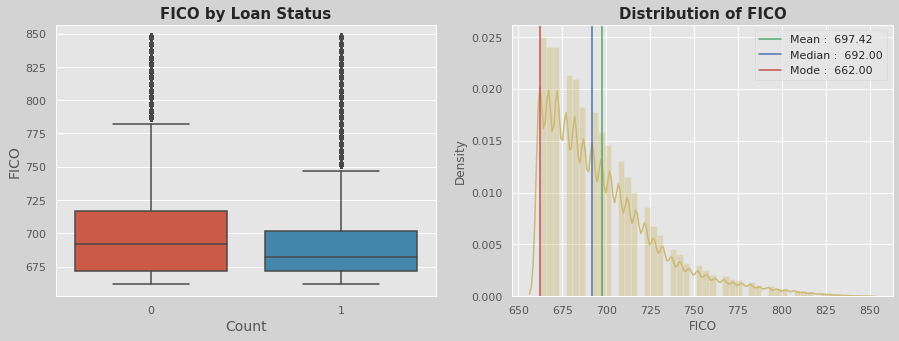

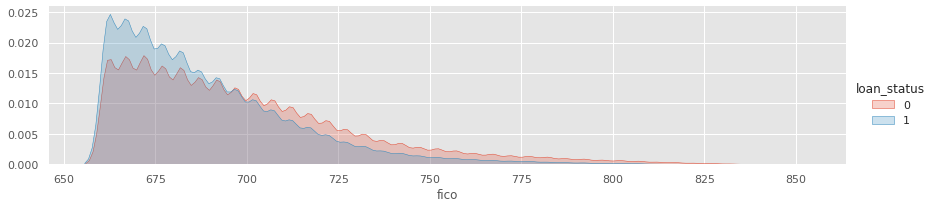

In [99]:
plot_numerical(data, 'fico', 'FICO')

In [100]:
data.groupby(['loan_status'])['fico'].describe()

StatementMeta(Spark1, 104, 100, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,699.450027,32.490418,662.0,672.0,692.0,717.0,847.5
1,256465.0,689.390899,25.652392,662.0,672.0,682.0,702.0,847.5


StatementMeta(Spark1, 104, 101, Finished, Available)

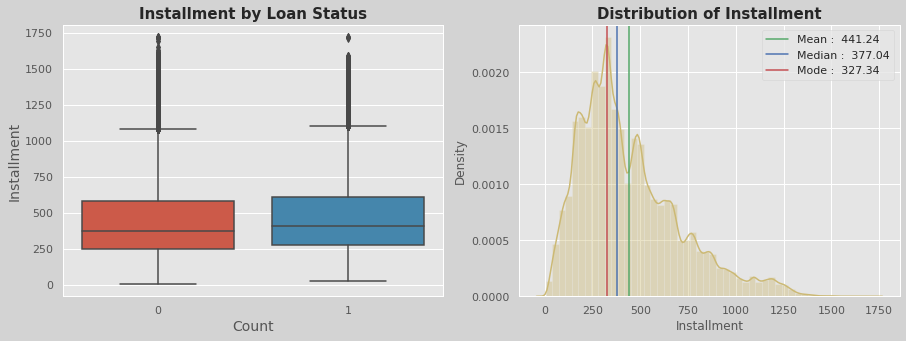

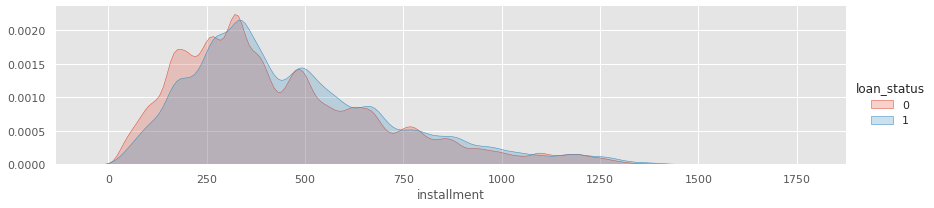

In [101]:
# installment - The monthly payment owed by the borrower if the loan originates.

plot_numerical(data, 'installment', 'Installment')

In [102]:
# Charged-off loans tend to have higher installments, so we should keep this feature

data.groupby(['loan_status'])['installment'].describe()

StatementMeta(Spark1, 104, 102, Finished, Available)

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,1013752.0,434.634823,261.308945,4.93,244.44,370.92,578.21,1719.83
1,256465.0,467.342103,262.555616,27.85,277.29,404.60,607.82,1717.63


In [103]:
list_missing_data()

StatementMeta(Spark1, 104, 103, Finished, Available)

'emp_length': number of missing values '76024' ==> '5.985%'
'revol_util': number of missing values '776' ==> '0.061%'


In [104]:
data.shape

StatementMeta(Spark1, 104, 104, Finished, Available)

(1270217, 24)

In [105]:
# Let's save cleaned data to csv

data.to_csv('***/Cleaned_data.csv')  

StatementMeta(Spark1, 104, 105, Finished, Available)